In [2]:
from geodude.parameter import Parameter
from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from scipy import stats
from shapely.geometry import (
    box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString)
from shapely.affinity import translate, rotate, scale
from pathlib import Path
from dataclasses import dataclass
from fn.namer import new_plot_id
%load_ext autoreload
%autoreload 2

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/geodude/utils.py:70: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if getattr(mls, "type") == "MultiLineString":
/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/geodude/utils.py:72: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif getattr(mls, "type") == "LineString":


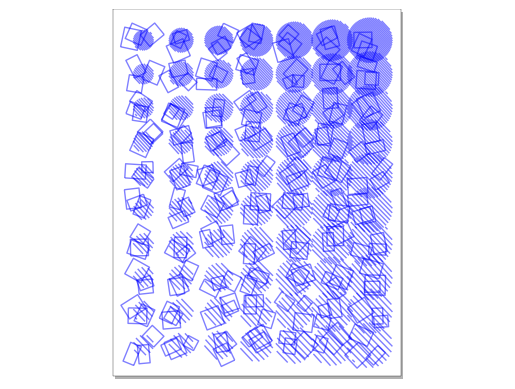

In [3]:

# Define geometric primitives
def hatch_filled_circle(center, radius, hatch_angle, hatch_spacing):
    circle = Point(center).buffer(radius)
    bounds = circle.bounds
    min_x, min_y, max_x, max_y = bounds
    lines = []
    angle_rad = np.deg2rad(hatch_angle)
    x_start = min_x - (max_y - min_y)
    x_end = max_x + (max_y - min_y)
    y_start = min_y
    y_end = max_y
    
    current_x = x_start
    while current_x < x_end:
        p1 = (current_x, y_start)
        p2 = (current_x + (y_end - y_start), y_end)
        line = rotate(LineString([p1, p2]), angle_rad, origin=center).intersection(circle)
        if line.length > 0:
            lines.append(line)
        current_x += hatch_spacing
    return MultiLineString(lines)

def rotated_rectangle(center, width, height, angle):
    rectangle = box(center[0] - width / 2, center[1] - height / 2, center[0] + width / 2, center[1] + height / 2)
    return rotate(rectangle, angle, origin=center)

# Composition
num_circles_x = 7
num_circles_y = 10
circle_spacing_x = (drawbox.bounds[2] - drawbox.bounds[0]) / (num_circles_x - 1)
circle_spacing_y = (drawbox.bounds[3] - drawbox.bounds[1]) / (num_circles_y - 1)

all_lines = []

for i in range(num_circles_x):
    for j in range(num_circles_y):
        center_x = drawbox.bounds[0] + i * circle_spacing_x
        center_y = drawbox.bounds[1] + j * circle_spacing_y
        radius = Parameter(10 + i * 2)
        hatch_angle = Parameter(lambda: np.random.uniform(0, 180))
        hatch_spacing = Parameter(2 + j * 0.5)
        circle_lines = hatch_filled_circle((center_x, center_y), radius(), hatch_angle(), hatch_spacing())
        all_lines.extend(circle_lines.geoms)
        
        num_rectangles = 3
        for _ in range(num_rectangles):
            rect_center_x = center_x + Parameter(lambda: np.random.uniform(-circle_spacing_x / 3, circle_spacing_x / 3))()
            rect_center_y = center_y + Parameter(lambda: np.random.uniform(-circle_spacing_y / 3, circle_spacing_y / 3))()
            width = Parameter(lambda: np.random.uniform(10, 20))()
            height = Parameter(lambda: np.random.uniform(10, 20))()
            angle = Parameter(lambda: np.random.uniform(0, 360))()
            rectangle = rotated_rectangle((rect_center_x, rect_center_y), width, height, angle)
            rectangle_lines = MultiLineString([rectangle.exterior])
            all_lines.extend(rectangle_lines.geoms)

# Merge all the LineStrings into a single MultiLineString and draw it
final_multilinestring = merge_LineStrings(all_lines)

sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(final_multilinestring)
sk.display()


In [22]:
sk.vpype('splitall linemerge linesort')

plot_id = '20230316_gpt4_01_harmonious_duality'

savedir = 'outputs'
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/naka/art_code/brr/libraries/geodude/geodude/utils.py:70: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if getattr(mls, "type") == "MultiLineString":
/Users/naka/art_code/brr/libraries/geodude/geodude/utils.py:72: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif getattr(mls, "type") == "LineString":


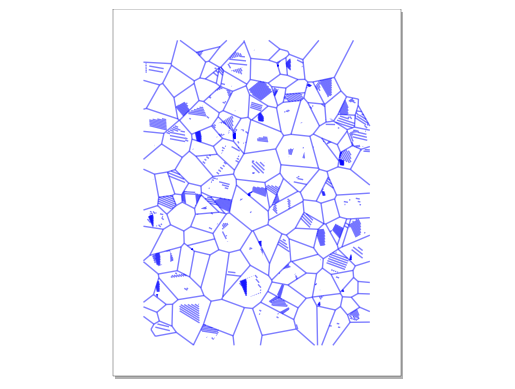

In [41]:
from geodude.parameter import Parameter
from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import (
    box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString)
from shapely.ops import polygonize, unary_union
from dataclasses import dataclass
from pathlib import Path
from shapely.affinity import rotate, translate
%load_ext autoreload
%autoreload 2

# Create the VoronoiConfig dataclass
@dataclass
class VoronoiConfig:
    num_points: int
    seed: int
    
@dataclass
class RectangleConfig:
    num_rectangles: int
    width_range: tuple
    height_range: tuple
    angle_range: tuple
    
@dataclass
class HatchConfig:
    angle_range: tuple
    spacing_range: tuple

def rotated_rectangle(center, width, height, angle_degrees):
    rectangle = box(-width / 2, -height / 2, width / 2, height / 2)
    rotated = rotate(rectangle, angle_degrees, origin=(0, 0), use_radians=False)
    translated = translate(rotated, *center)
    return translated

def hatch_filled_polygon(polygon, angle_degrees, spacing):
    bounds = polygon.bounds
    lower_left = (bounds[0], bounds[1])
    upper_right = (bounds[2], bounds[3])

    width = upper_right[0] - lower_left[0]
    height = upper_right[1] - lower_left[1]

    diagonal_length = np.hypot(width, height)
    angle_radians = np.radians(angle_degrees)

    num_lines = int(diagonal_length / spacing) + 1

    hatch_lines = []
    for i in range(num_lines):
        y = lower_left[1] - height + i * spacing
        start = (lower_left[0], y)
        end = (lower_left[0] + diagonal_length * np.cos(angle_radians), y + diagonal_length * np.sin(angle_radians))
        line = LineString([start, end])
        clipped_line = polygon.buffer(1e-9).intersection(line)
        if clipped_line.length > 0:
            hatch_lines.append(clipped_line)

    return hatch_lines

# Define the function to generate Voronoi edges
def voronoi_edges(voronoi_config: VoronoiConfig, drawbox: Polygon):
    np.random.seed(voronoi_config.seed)
    points = np.random.uniform([drawbox.bounds[0], drawbox.bounds[1]], [drawbox.bounds[2], drawbox.bounds[3]], (voronoi_config.num_points, 2))
    vor = Voronoi(points)
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    lines = [line for line in lines if line.intersects(drawbox) and line.length > 0]
    clipped_lines = [drawbox.intersection(line) for line in lines ]
    return clipped_lines, vor


def generate_rectangles_in_cells(cells, rectangle_config: RectangleConfig, hatch_config: HatchConfig):
    all_rectangles = []
    for cell in cells:
        cell_rectangles = []
        for _ in range(rectangle_config.num_rectangles):
            width = Parameter(lambda: np.random.uniform(*rectangle_config.width_range))()
            height = Parameter(lambda: np.random.uniform(*rectangle_config.height_range))()
            angle = Parameter(lambda: np.random.uniform(*rectangle_config.angle_range))()
            
            point_in_cell = Point(cell.representative_point())
            rectangle = rotated_rectangle(point_in_cell.coords[0], width, height, angle)

            # Cut away pieces of a rectangle that are in areas already occupied by another rectangle
            for r in cell_rectangles:
                rectangle = rectangle.difference(r)

            # Cut away pieces of a rectangle that are outside of the parent Voronoi cell
            if rectangle.intersects(cell):
                rectangle = cell.intersection(rectangle)
                cell_rectangles.append(rectangle)

                # Add hatching to the rectangle
                hatch_angle = Parameter(lambda: np.random.uniform(*hatch_config.angle_range))()
                hatch_spacing = Parameter(lambda: np.random.uniform(*hatch_config.spacing_range))()
                hatched_rectangle = hatch_filled_polygon(rectangle, hatch_angle, hatch_spacing)
                all_rectangles.extend(hatched_rectangle)
    return all_rectangles


# Make the paper and drawbox
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)

# Configuration
rectangle_config = RectangleConfig(num_rectangles=3, width_range=(10, 20), height_range=(10, 20), angle_range=(0, 360))
hatch_config = HatchConfig(angle_range=(0, 180), spacing_range=(1, 4))

# Generate Voronoi cells
# Create the Voronoi configuration
voronoi_config = VoronoiConfig(num_points=150, seed=42)

# Generate Voronoi edges
clipped_lines, vor = voronoi_edges(voronoi_config, drawbox)

voronoi_cells = [Polygon(vor.vertices[cell]) for cell in vor.regions if -1 not in cell and len(cell) > 0]
clipped_cells = [drawbox.intersection(cell) for cell in voronoi_cells]

# Generate rectangles
rectangles = generate_rectangles_in_cells(clipped_cells, rectangle_config, hatch_config)


# Merge Voronoi edges and rectangles into a single MultiLineString and draw it
final_multilinestring = merge_LineStrings(clipped_lines + rectangles)


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(final_multilinestring)
sk.display()


In [42]:
sk.vpype('splitall linemerge linesort')

plot_id = '20230316_gpt4_02_harmonious_duality'

savedir = 'outputs'
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)